In [1]:
%gui qt

This notebook is an example of how to analyze the thickness of a layer of tissue.

## Generate mock data
First, we generate a set of mock data simulating a slab of tissue with three layers.

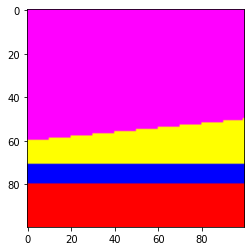

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import draw
from skimage.color import label2rgb

# image size
im_width = 100
im_height = 100

# create the empty image
mock_image_profile = 4 * np.ones((im_height, im_width), dtype=np.uint)

# add layer 1
rr_1, cc_1 = draw.rectangle((80, 0), extent=(20, im_width), shape=mock_image_profile.shape)
mock_image_profile[rr_1, cc_1] = 1

# add layer 2
rr_2, cc_2 = draw.rectangle((70, 0), extent=(10, im_width), shape=mock_image_profile.shape)
mock_image_profile[rr_2, cc_2] = 2

# add layer 3
r_3 = np.array([70, 60, 50, 70])
c_3 = np.array([0, 0, 99, 99])
rr_3, cc_3 = draw.polygon(r_3, c_3)
mock_image_profile[rr_3, cc_3] = 3


plt.imshow(label2rgb(mock_image_profile, bg_label=0));

In [3]:
import napari
mock_image = np.tile(mock_image_profile, (100, 1, 1))

colors = {
    0: [0, 0, 0, 0],
    1: [0.5, 0.79, 0.5, 1],
    2: [0.75, 0.68, 0.83, 1],
    3: [0.99, 0.75, 0.52, 1],
    4: [0, 0, 0, 1]
}
viewer = napari.view_labels(mock_image, color=colors, opacity=0.4)

In [5]:
from morphologyanalysis.volume.label import label_boundaries
edge_labels = label_boundaries(mock_image)

# add the edge label image to the napari viewer
viewer.add_labels(edge_labels, color=colors);

In [27]:
from morphologyanalysis.surface.mesh import mesh_from_interface

surf_bot = mesh_from_interface(label_im=edge_labels, parent_label=3, neighbor_label=2)
surf_top = mesh_from_interface(label_im=edge_labels, parent_label=3, neighbor_label=4)

In [28]:
import pyvista as pv

p1 = pv.PlotterITK()
p1.add_mesh(surf_top, smooth_shading=True)
p1.add_mesh(surf_bot, smooth_shading=True)
p1.show();

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [15]:
surf_bot_n["distances"] = np.empty(surf_bot.n_points)
for i in range(surf_bot_n.n_points):
    p = surf_bot_n.points[i]
    vec = surf_bot_n["Normals"][i] * surf_bot_n.length
    p0 = p - vec
    p1 = p + vec
    ip, ic = surf_top.ray_trace(p0, p1, first_point=True)
    dist = np.sqrt(np.sum((ip - p)**2))
    surf_bot_n["distances"][i] = dist

# Replace zeros with nans
mask = surf_bot_n["distances"] == 0
surf_bot_n["distances"][mask] = np.nan
np.nanmean(surf_bot_n["distances"])


14.51

In [17]:
p2 = pv.PlotterITK()
p2.add_mesh(surf_bot_n, scalars="distances", smooth_shading=True)
p2.add_mesh(surf_top, opacity=0.75, smooth_shading=True)
p2.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…